# Car Price Prediction

In [117]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from bs4 import BeautifulSoup as bs
import requests
import re
import time
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
%matplotlib inline

## Getting scraped data from csv file

In [89]:
df = pd.read_csv('data/car_info.csv', index_col=0)

In [90]:
df = df.dropna()

## Data cleaning

### Fuel type

In [91]:
def is_gas(row):
    regex1 = re.compile('.*Gas.*')
    regex2 = re.compile('.*Flex.*')
    if regex1.match(row.fuel_type) or \
    regex2.match(row.fuel_type) or \
    row.fuel_type == 'Hybrid ':
        return 1
    else:
        return 0
    
def is_diesel(row):
    regex1 = re.compile('Diesel.*')
    regex2 = re.compile('.*Flex Fuel.*')
    if regex1.match(row.fuel_type) or \
    regex2.match(row.fuel_type):
        return 1
    else:
        return 0
    
def is_electric(row):
    regex = re.compile('.*Electric.*')
    if regex.match(row.fuel_type) or \
    row.fuel_type == 'Hybrid ':
        return 1
    else:
        return 0

In [92]:
df['is_gas'] = df.apply(lambda row : is_gas(row), axis=1)
df['is_diesel'] = df.apply(lambda row : is_diesel(row), axis=1)
df['is_electric'] = df.apply(lambda row : is_electric(row), axis=1)

### Year

In [93]:
def get_year_make_model(row):
    i = row['name']
    w = i.split()
    return w

In [94]:
df['year'] = df.apply(lambda row : get_year_make_model(row)[0], axis=1)\
    .astype('int')
df['make'] = df.apply(lambda row : get_year_make_model(row)[1], axis=1)
df['model'] = df.apply(lambda row : get_year_make_model(row)[2], axis=1)

### MPG

In [95]:
# drop rows with blank mpg
df = df[df['mpg'] != '–']
df = df[df['mpg'] != 'None']

In [96]:
def get_low_mpg(row):
    i = row.mpg.find('–')
    if i != -1:
        return row.mpg[0:i]
    else:
        return row.mpg

def get_high_mpg(row):
    i = row.mpg.find('–')
    if i != -1:
        return row.mpg[i+1:]
    else:
        return 0

In [97]:
df['low_mpg'] = df.apply(lambda row : get_low_mpg(row), axis=1)
df['high_mpg'] = df.apply(lambda row : get_high_mpg(row), axis=1)

In [98]:
df.dropna()
df['low_mpg'] = df['low_mpg'].astype('int')
df['high_mpg'] = df['high_mpg'].astype('int')

### Transmission

In [99]:
def is_auto(row):
    regex = re.compile('.*([A|a]uto|A/T|Dual Shift).*')
    if regex.match(row.transmission):
        return 1
    else:
        return 0

def is_cvt(row):
    regex = re.compile('.*(CVT|Variable).*')
    if regex.match(row.transmission):
        return 1
    else:
        return 0
    
def is_manual(row):
    regex = re.compile('.*(Manual|M/T).*')
    if regex.match(row.transmission):
        return 1
    else:
        return 0
    
def get_speed(row):
    tmp = row.transmission
    tmp = re.sub('[^0-9]', '', tmp)
    if tmp == '':
        return 0
    else:
        return int(tmp)

In [100]:
df['is_auto'] = df.apply(lambda row : is_auto(row), axis=1)
df['is_cvt'] = df.apply(lambda row : is_cvt(row), axis=1)
df['is_manual'] = df.apply(lambda row : is_manual(row), axis=1)
df['speed'] = df.apply(lambda row : get_speed(row), axis=1)

### Engine

In [101]:
def get_L(row):
    i = row.engine.find('L')
    if i == -1:
        return 0
    else:
        return float(row.engine[i-3:i])

def get_V(row):
    i = row.engine
    a = re.compile('.*16V.*')
    b = re.compile('.*24V.*')
    c = re.compile('.*32V.*')
    d = re.compile('.*48V.*')
    e = re.compile('.*12V.*')
    if a.match(i):
        return 16
    elif b.match(i):
        return 24
    elif c.match(i):
        return 32
    elif d.match(i):
        return 48
    elif e.match(i):
        return 12
    else:
        return 0

In [102]:
df['engine_L'] = df.apply(lambda row : get_L(row), axis=1).astype('float')
df['engine_V'] = df.apply(lambda row : get_V(row), axis=1).astype('float')

### Drive train

In [103]:
# drop rows with blank drivetrain
df.drivetrain = df.drivetrain.apply(lambda x : x[1:-1])
df = df[df['drivetrain'] != '–']

In [104]:
def get_drivetrain(row):
    i = row.drivetrain
    four = re.compile('.*(Front|Rear|FWD).*')
    two = re.compile('.*(All|Four|4WD|AWD).*')
    if four.match(i):
        return 4
    elif two.match(i):
        return 2
    else:
        return 0

In [105]:
df['drivetrain'] = df.apply(lambda row : get_drivetrain(row), axis=1)

### Drop useless columns

In [106]:
df = df.drop(columns=\
             ['name', 'ex_color', 'in_color', \
              'mpg', 'fuel_type', 'transmission', 'engine'])

In [107]:
df.head()

,index,price,mileage,drivetrain,is_gas,is_diesel,is_electric,year,make,model,low_mpg,high_mpg,is_auto,is_cvt,is_manual,speed,engine_L,engine_V
0,0,27995.0,29192,4,1,0,0,2019,Honda,Accord,29,35,1,1,0,0,1.5,16.0
1,1,52458.0,56059,2,0,0,1,2019,Tesla,Model,120,112,1,0,0,1,0.0,0.0
2,2,22115.0,15039,4,1,0,0,2020,Toyota,Corolla,30,38,1,1,0,0,1.8,16.0
3,3,19500.0,61754,2,1,0,0,2017,Volkswagen,Golf,22,30,1,0,0,6,1.8,16.0
4,4,34952.0,26577,2,1,0,0,2020,Ford,Edge,21,28,1,0,0,8,2.0,16.0


## Building regression model

## Virtualization

In [108]:
# drop columns not used for now
drop_column_names = ['make', 'model']
df = df.drop(columns = drop_column_names, axis=1)

In [109]:
# sns.pairplot(df)

### Divide dataset

In [110]:
train_df, test_df = train_test_split(df, test_size=0.2)

### Fit model

In [112]:
X = train_df.drop(columns='price', axis=1)
y = train_df.price

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [113]:
model.score(X, y)

0.3266804786229679

In [114]:
# test
X_test = test_df.drop(columns='price', axis=1)
y_test = test_df.price
model.score(X_test, y_test)

0.2250165975872621

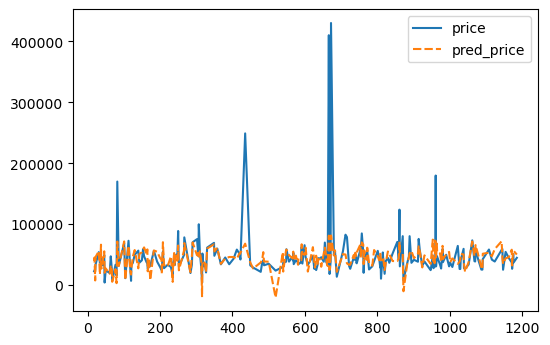

In [119]:
# model.predict(X_test)
plt.figure(dpi=100)
df_res = pd.DataFrame()
df_res['price'] = y_test
df_res['pred_price'] = model.predict(X_test)
ax = sns.lineplot(data=df_res)